**Importing Required Libraries and Modules :**

In [2]:
import os
import glob
import zipfile
import pycountry
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns

**Unzip the main file :**

In [ ]:
with zipfile.ZipFile("202405.zip", "r") as zfile:
    zfile.extractall()

#remove zip file after unzipping
os.remove("202405.zip")

**Unzip each day :**

In [ ]:
files = glob.glob("/202405/2024*.zip")

#unzip each file that begin with 2024
for file in files:
    extraction_path = f"/202405/{os.path.splitext(os.path.basename(file))[0]}/"
    with zipfile.ZipFile(file, "r") as zfile2:
        zfile2.extractall(extraction_path)
    
    #remove zip files after unzipping
    os.remove(file)

**Saving data into csv formats :**

In [ ]:
# Specify the directory path
directory_path = '/202405'

# Specify the prefixes you want to filter files with
prefixes = ['away_team_1','away_team_score','event','home_team_1','home_team_score','round','season','time','tournament','venue','odds', 'pbp' ,'statistics' ,'power', 'votes']

# Function to read and concatenate Parquet files for a given prefix
def read_concat_parquet_files(prefix):
    filtered_files = [os.path.join(root, file) for root, _, files in os.walk(directory_path) for file in files if file.startswith(prefix)]
    df = [pd.read_parquet(file, engine='pyarrow') for file in filtered_files]
    result_df = pd.concat(df, ignore_index=True)
    
    # Save the DataFrame to a CSV file with the corresponding prefix
    result_df.to_csv(f'{directory_path}/df_{prefix}.csv', index=False)
    
    return prefix, result_df

# Dictionary to store DataFrames
dfs = {}

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    results = executor.map(read_concat_parquet_files, prefixes)

# Store the results in the dictionary
for prefix, result_df in results:
    key = f'df_{prefix}'  # Use the prefix as the key in the dictionary
    dfs[key] = result_df

# Access each DataFrame from the dictionary with the prefix as part of the key
for key in dfs:
    globals()[key] = dfs[key]

**1. How many tennis players are included in the dataset?**

In [11]:
match_away_team_info = pd.read_csv('df/df_away_team_1.csv').drop_duplicates(subset='match_id', keep='first')
match_home_team_info = pd.read_csv('df/df_home_team_1.csv').drop_duplicates(subset='match_id', keep='first')
total_team_info = pd.merge(match_away_team_info, match_home_team_info, how='outer')
total_team_info['player_id'].nunique()

2352

**2. What is the average height of the players?**

In [28]:
total_team_info['height'].mean()

np.float64(1.8194051990013218)

**3. Which player has the highest number of wins?**

In [36]:
df_pbp = pd.read_csv('project1/df/df_pbp.csv')

# Assuming df is your DataFrame with columns: match_id, set_id, game_id, point_id, home_point, away_point
# Find the row with the maximum point_id for each game_id
max_point_rows = df_pbp.loc[df_pbp.groupby(['match_id','set_id','game_id'])['point_id'].idxmax()]

# Replace a unique value in the 'home_point' column with a new value
max_point_rows['home_point'] = max_point_rows['home_point'].replace('A', '60')

# Replace a unique value in the 'away_point' column with a new value
max_point_rows['away_point'] = max_point_rows['away_point'].replace('A', '60')

# Calculate the winner of each game based on the condition
max_point_rows['game_winner'] = max_point_rows.apply(lambda x: 'home' if x['home_point'] > x['away_point'] else 'away' if x['home_point'] < x['away_point']  else None, axis=1)

# Calculate the player with the most wins in each game
game_winners = max_point_rows.groupby(['match_id', 'set_id', 'game_id', 'game_winner'])['game_winner'].count().reset_index(name='win_count')
max_game_winners = game_winners.loc[game_winners.groupby(['match_id', 'set_id', 'game_id'])['win_count'].idxmax()]

# Determine the winner of each set
set_winners = max_game_winners.groupby(['match_id', 'set_id', 'game_winner'])['game_winner'].count().reset_index(name='set_win_count')
max_set_winners = set_winners.loc[set_winners.groupby(['match_id', 'set_id'])['set_win_count'].idxmax()]

# Determine the winner of the match
match_winners = max_set_winners.groupby(['match_id', 'game_winner'])['game_winner'].count().reset_index(name='match_win_count')
max_match_winner = match_winners.loc[match_winners.groupby('match_id')['match_win_count'].idxmax()]

# The final winner of each match
df_match_winners = max_match_winner[['match_id', 'game_winner']].rename(columns={'game_winner': 'match_winner'})

# Save the winners for each match_id in a new DataFrame
df_match_winners.to_csv('match_winners.csv')

#apply player_id colums to my match_winners dataframe
#open player dataframe
df_home_team_1 = pd.read_csv('project1/df/df_home_team_1.csv').drop_duplicates(subset='match_id')
df_away_team_1 = pd.read_csv('project1/df/df_away_team_1.csv').drop_duplicates(subset='match_id')

#seprate away and home player to single dataframe for merge
df_match_winners_away = df_match_winners.loc[df_match_winners['match_winner'] == 'away',  ['match_id','match_winner']]
df_match_winners_home = df_match_winners.loc[df_match_winners['match_winner'] == 'home',  ['match_id','match_winner']]

#merge df to find player id winner for each match
df_match_winners_away_with_player_id = df_match_winners_away.merge(df_away_team_1[['player_id','match_id']] , on='match_id', how='left')
df_match_winners_home_with_player_id = df_match_winners_home.merge(df_home_team_1[['player_id','match_id']] , on='match_id', how='left')

#concate home and away dataframe winner
df_match_winners_with_player_id = pd.concat([df_match_winners_away_with_player_id,df_match_winners_home_with_player_id] )

# each player how many wins series
df_match_winners_with_player_id = df_match_winners_with_player_id.dropna()
df_match_winners_with_player_id.groupby('player_id')['match_id'].count()

#player_id of who can top wins match in touroments
df_match_winners_with_player_id.groupby('player_id')['match_id'].count().idxmax()

np.float64(253356.0)

**4. What is the longest match recorded in terms of duration?**

In [12]:
match_time_info = pd.read_csv('df/df_time.csv').drop_duplicates(subset='match_id', keep='first')
match_time_info['Total'] = match_time_info.iloc[:, 1:5].sum(axis=1)
match_time_info.loc[match_time_info['Total'].idxmax(), 'match_id']

np.int64(12346747)

**5. How many sets are typically played in a tennis match?**

In [9]:
organized_game_info = pd.read_csv('df/df_pbp.csv').groupby('match_id')['set_id'].max().reset_index()
organized_game_info['set_id'].value_counts()

set_id
2    4518
3    1920
1      68
4      29
5      20
Name: count, dtype: int64

Typically 2 sets are played in a tennis match.

**6. Which country has produced the most successful tennis players?**

In [10]:
organized_team_info = total_team_info.drop_duplicates(subset='player_id', keep='first').groupby('country')['current_rank'].mean().reset_index()
organized_team_info.sort_values(by = 'current_rank')

,country,current_rank
69,Philippines,160.000000
55,Malta,300.000000
1,Andorra,310.000000
87,Tunisia,330.000000
84,Syria,345.000000
...,...,...
63,Nigeria,1257.333333
6,Azerbaijan,1277.000000
2,Antigua and Barbuda,1497.000000
72,Qatar,NaN


Philippines has produced the most successful players.

**7. What is the average number of aces per match?**

In [21]:
period_info = pd.read_csv('df/df_statistics.csv')
period_info.groupby('match_id')['statistic_name'].apply(lambda x: (x == 'aces').sum()).mean()

np.float64(6.49257025158158)

**8. Is there a difference in the number of double faults based on gender?**

In [22]:
organized_period_info = period_info.groupby('match_id')['statistic_name'].apply(lambda x: (x == 'double_faults').sum()).reset_index(name='double_faults')
pd.merge(match_away_team_info, organized_period_info, how='outer').groupby('gender')['double_faults'].mean()

gender
F    6.416489
M    6.624333
Name: double_faults, dtype: float64

In [41]:
(0.5-(6.41/(6.416489+6.624333))) * 100

0.8466567521587198

Gender effects double faults less than one percent .

**10. Is there a correlation between a player's height and their ranking?**

**9. Which player has won the most tournaments in a single month?**

In [ ]:
#open dataframe
df_tournament = pd.read_csv('project1/df/df_tournament.csv').drop_duplicates(subset='match_id')
df_match_winners = pd.read_csv('project1/df/match_winner.csv')
#open df_round
df_round = pd.read_csv('project1/df/df_round.csv')
# add tornament_id for each match in df_match winner
df_match_winners_with_tournament = df_match_winners.merge(df_tournament[['tournament_id', 'match_id']] , on='match_id', how='left')

df_round_finall = df_round.loc[df_round['slug'] == 'final'].drop_duplicates('match_id')
#merge to find winner of last match of each tournament to see who win tournament
df_match_winners_final_match_of_each_tournament = df_match_winners_with_tournament.merge(df_round_finall[ 'match_id'] , on='match_id', how='right').dropna(subset=['tournament_id'])
int(df_match_winners_final_match_of_each_tournament.groupby('player_id')['tournament_id'].count().idxmax())

In [29]:
total_team_info = pd.merge(match_away_team_info, match_home_team_info, how='outer')
total_team_info['height'].corr(total_team_info['current_rank'])

np.float64(0.11238320058640809)

This number is near zero so they have a weak correlation.

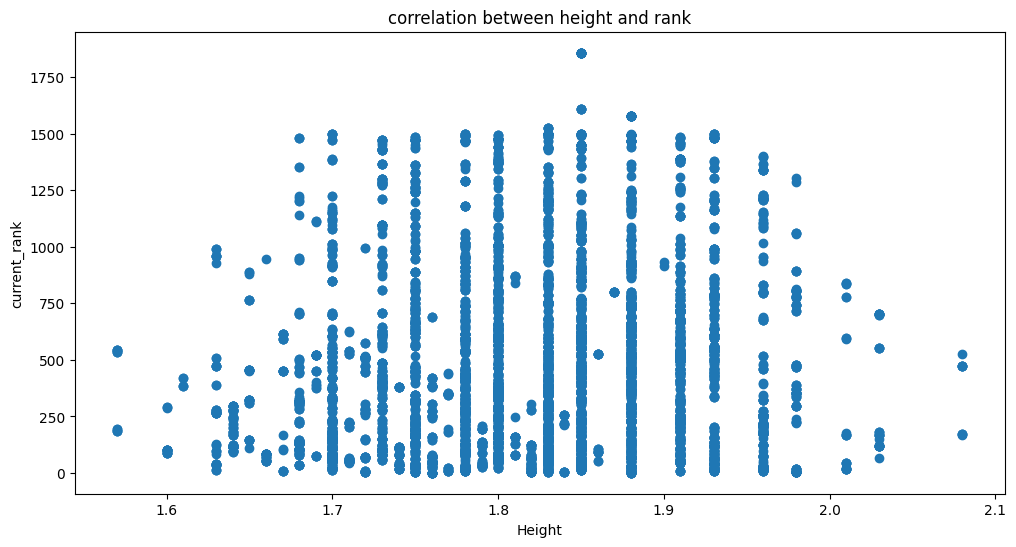

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the scatter plot
ax.scatter(total_team_info['height'], total_team_info['current_rank'])

# Set axis labels
ax.set_xlabel('Height')
ax.set_ylabel('current_rank')

#Set the title
ax.set_title('correlation between height and rank')

# Show the plot
plt.show()

You can't see a pattern so there isn't a correlation. 

**11. What is the average duration of matches?**

In [31]:
match_time_info = pd.read_csv('df/df_time.csv').drop_duplicates(subset='match_id', keep='first')
match_time_info['Total'] = match_time_info.iloc[:, 1:5].sum(axis=1)
match_time_info[match_time_info['Total'] != 0]['Total'].mean()

np.float64(7331.208374223094)

**12. What is the average number of games per set in men's matches compared to women's matches?**

In [42]:
game_info = pd.read_csv('df/df_pbp.csv')
organized_game_info_2 = game_info.groupby(['match_id', 'set_id'])['game_id'].mean().reset_index(name='mean_game_id')
pd.merge(match_away_team_info, organized_game_info_2, how='inner').groupby('gender')['mean_game_id'].mean()

gender
F    5.037571
M    5.211970
Name: mean_game_id, dtype: float64

**13. What is the distribution of left-handed versus right-handed players?**

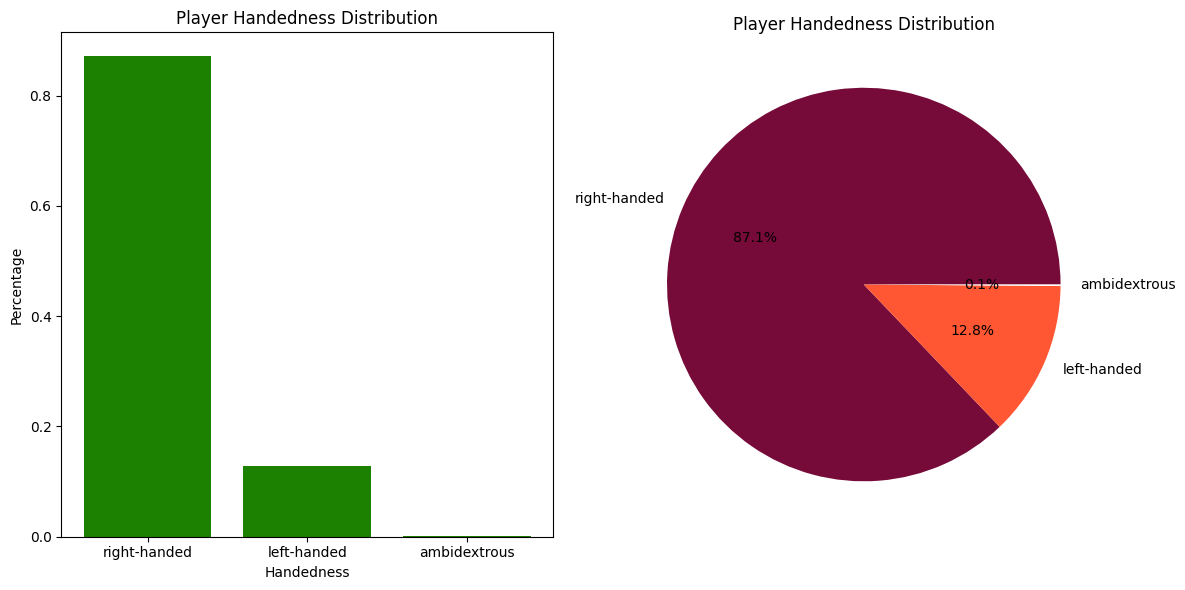

In [5]:
match_away_team_info = pd.read_csv('project1/df/df_away_team_1.csv').drop_duplicates(subset='match_id', keep='first')
match_home_team_info = pd.read_csv('project1/df/df_home_team_1.csv').drop_duplicates(subset='match_id', keep='first')
total_team_info = pd.merge(match_away_team_info, match_home_team_info, how='outer')
handedness_count = total_team_info['plays'].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
ax1.bar(handedness_count.index,handedness_count.values, color='#1C8001')
ax1.set_xlabel('Handedness')
ax1.set_ylabel('Percentage')
ax1.set_title('Player Handedness Distribution')
ax1.tick_params(axis='x', labelrotation=0)

# Pie chart
colors = ['#760A38', '#FF5733', '#FFFFFF', '#000000']
ax2.pie(handedness_count.values, colors=colors, labels=handedness_count.index, autopct='%1.1f%%')
ax2.set_title('Player Handedness Distribution')

plt.tight_layout()
plt.show()

**14. What is the most common type of surface used in tournaments?**

In [15]:
pd.read_csv('df/df_tournament.csv').drop_duplicates(subset='tournament_id', keep='first').groupby('ground_type')['tournament_id'].count().reset_index()

,ground_type,tournament_id
0,Hardcourt indoor,4
1,Hardcourt outdoor,75
2,Red clay,213
3,Synthetic outdoor,2


Red clay is the most common type of surface.

**15. How many distinct countries are represented in the dataset?**

In [59]:
match_venue_info = pd.read_csv('df/df_venue.csv').drop_duplicates(subset='match_id', keep='first')
a = match_venue_info['country'].unique()
match_total_info = pd.merge(match_away_team_info, match_home_team_info, how='outer')
residence_country = match_total_info['residence'].unique()

# Create a list of valid countries using pycountry
valid_countries = [country.name for country in pycountry.countries]

# Obtain the unique countries
unique_countries = []
for place in residence_country:
    if isinstance(place, str):
        if ',' in place:
            country = place.split(',')[-1].strip()
        else:
            country = place
        
        # Validate the extracted country name using the valid_countries list
        if country in valid_countries:
            unique_countries.append(country)

# Remove duplicate countries and convert to NumPy array
unique_countries = np.array(list(set(unique_countries)))

total_countries = np.concatenate((match_total_info['country'], match_venue_info['country'], unique_countries))
len(np.unique(total_countries))


103

**16. Which player has the highest winning percentage against top 10 ranked opponents?**

In [ ]:
#opend and prepare df
df_rank_player_winners = pd.read_csv('df_rank_player_winners.csv')

df_home_team_1 = pd.read_csv('df/df_home_team_1.csv').drop_duplicates(subset='match_id')
df_away_team_1 = pd.read_csv('df/df_away_team_1.csv').drop_duplicates(subset='match_id')
df_home_team_1['team_type'] = 'home'
df_away_team_1['team_type'] = 'away'
df_team = pd.concat([df_home_team_1,df_away_team_1],ignore_index=True)
#top 10 rank df
df_rank_player = df_team[['match_id','player_id','current_rank']].sort_values('current_rank',ascending=True).dropna()
df_top_10_rank_player = df_rank_player.loc[df_rank_player['current_rank']<= 10 , ['match_id','player_id','current_rank']]
#create df match winer losser id

df_player_id_details_0 =df_match_winners[['match_id','match_winner','player_id']].merge(df_team[['player_id','match_id','team_type']] , on='match_id', suffixes=('_winner', '_losser'))
df_player_id_details = df_player_id_details_0[~(df_player_id_details_0['player_id_winner'] == df_player_id_details_0['player_id_losser'])]
df_player_id_winner_losser = df_player_id_details[['match_id','player_id_winner','player_id_losser']]

In [ ]:
#compare
winner_againt_top_10 = []
for top_player in df_top_10_rank_player['player_id']:
    # Check if the winner is in df_player_id_winner_losser['player_id_losser']
    if top_player in df_player_id_winner_losser['player_id_losser'].values:
        # Get the corresponding player_id_winner for the match
        player_id_winner = int(df_player_id_winner_losser.loc[df_player_id_winner_losser['player_id_losser'] == top_player, 'player_id_winner'].values[0])
        winner_againt_top_10.append(player_id_winner)

winner_againt_top_10

In [ ]:
top_winner_againt_top_10_id = max(set(winner_againt_top_10), key = winner_againt_top_10.count)
max_repeats = winner_againt_top_10.count(top_winner_againt_top_10_id)
top_winner_againt_top_10_id

**17. What is the average number of breaks of serve per match?**

In [57]:
period_info = pd.read_csv('df/df_statistics.csv')
organized_period_info = period_info[period_info['statistic_name'] == 'break_points_converted'].groupby('match_id').size().reset_index(name='total')
organized_period_info['total'].mean()

np.float64(6.49257025158158)

**18. Does experience affect player's rank?** 

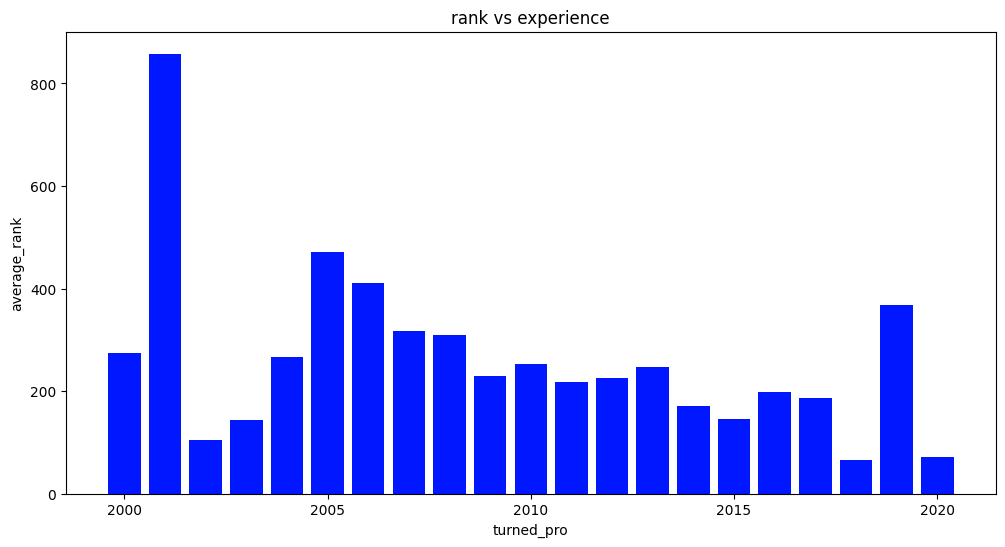

In [14]:
match_away_team_info = pd.read_csv('project1/df/df_away_team_1.csv').drop_duplicates(subset='match_id', keep='first')
match_home_team_info = pd.read_csv('project1/df/df_home_team_1.csv').drop_duplicates(subset='match_id', keep='first')
total_team_info = pd.merge(match_away_team_info, match_home_team_info, how='outer')
organized_team_info = total_team_info.groupby('turned_pro')['current_rank'].mean().reset_index()

# Bar plot
fig, (ax1) = plt.subplots(figsize=(12, 6))
ax1.bar(organized_team_info['turned_pro'],organized_team_info['current_rank'], color='#0017FF')
ax1.set_xlabel('turned_pro')
ax1.set_ylabel('average_rank')
ax1.set_title('rank vs experience')
ax1.tick_params(axis='x', labelrotation=0)

We can't see a pattern here.

Players with 6 years experience have the best ranking.

Players with 23 years experience have the worst ranking.

**19. Does live streaming affect game suspension?**

In [18]:
odds_info = pd.read_csv('project1/df/df_odds.csv')
odds_info.groupby('is_live')['suspended'].count().reset_index()

,is_live,suspended
0,False,16768
1,True,16972


In [39]:
(0.5 - (16768/(16768 + 16972))) * 100

0.3023117960877286

Less than one percent live streaming affects game suspension.

**20. in which set more break of serves occur?**

In [25]:
power_info = pd.read_csv('project1/df/df_power.csv')
organized_power_info = power_info.groupby('set_num')['break_occurred'].mean().reset_index()
organized_power_info.sort_values(ascending=False, by = 'break_occurred')

,set_num,break_occurred
4,5,0.535714
3,4,0.524882
0,1,0.502430
1,2,0.499477
2,3,0.499000


We can see in the two last sets this number increase which can happen because of the tiredness.

**21. In which countries the most matches have been played?**

In [34]:
match_venue_info = pd.read_csv('project1/df/df_venue.csv').drop_duplicates(subset='match_id', keep='first')
organized_venue_info = match_venue_info.groupby('country')['match_id'].count().reset_index(name='total_match')
organized_venue_info.sort_values(ascending=False, by = 'total_match')

,country,total_match
12,France,803
31,Tunisia,796
16,Italy,725
28,Spain,715
24,Serbia,688
23,Romania,540
33,USA,432
7,Croatia,420
4,China,408
32,Turkey,400


**22. Does hosting increases the chance of winning?**

In [48]:
df_match_winners = pd.read_csv('match_winners.csv')
number_of_home_winner = int(df_match_winners['match_winner'].value_counts()['home'])
number_of_away_winner = int(df_match_winners['match_winner'].value_counts()['away'])
#winning home team chance
number_of_home_winner/len(df_match_winners['match_winner']) 

0.5096872616323417

In [49]:
((number_of_home_winner/len(df_match_winners['match_winner'])-(1-(number_of_home_winner/len(df_match_winners['match_winner'])))) )*100/2

0.9687261632341682

As you can see, hosting increases the chance of winning by almost 1%

**23. Check how the average match time has a relationship with the rank difference of two players? have the matches of players with close ranks usually  longer match time?**

In [ ]:
df_time = pd.read_csv('df/df_time.csv')
df_time = df_time.fillna(value=0)
df_time = df_time.drop_duplicates(subset='match_id')
df_time['total_peroid'] =  df_time['period_1']+ df_time['period_2']+ df_time['period_3']+ df_time['period_4']+ df_time['period_5']
df_time.sort_values(by='total_peroid')
match_time = df_time.groupby('match_id')['total_peroid'].max().reset_index()
#remove 0 match time values before get mean of that
match_time = match_time[match_time['total_peroid'] != 0]
match_time
match_time_Q3 = int(match_time['total_peroid'].quantile(0.75))
match_time['distance_to_Q3'] = match_time['total_peroid'] - match_time_Q3
long_match_time = match_time[match_time['distance_to_Q3']> 0]


AS you can see above there are 1529 long match

In [ ]:
#now we can see relation same rank player and this match
df_home_team_1 = pd.read_csv('df/df_home_team_1.csv').drop_duplicates(subset='match_id')
df_away_team_1 = pd.read_csv('df/df_away_team_1.csv').drop_duplicates(subset='match_id')
df_long_match_time_with_player_rank =long_match_time.merge(df_home_team_1[['match_id','current_rank']], on='match_id',how='left').rename(columns={'current_rank': 'home_player_rank'})
df_long_match_time_with_player_rank = df_long_match_time_with_player_rank.merge(df_away_team_1[['match_id','current_rank']], on='match_id',how='left').rename(columns={'current_rank': 'away_player_rank'})
df_long_match_time_with_player_rank['rank_distance']=abs(df_long_match_time_with_player_rank['home_player_rank']- df_long_match_time_with_player_rank['away_player_rank'])

sns.scatterplot(x='rank_distance', y='distance_to_Q3', data=df_long_match_time_with_player_rank)
plt.title('Relationship between rank_dastance and distance_to_Q3')
plt.show()

As you can see, most of these long games are in a small rank difference between the players
،And the more the rank difference increases, the less the race is longed

There is a large density of data in the rank difference range of 200 and we can save that

In [ ]:
#save df_200_rank_distance 
df_200_rank_distance = df_long_match_time_with_player_rank[df_long_match_time_with_player_rank['rank_distance']<=200]
len(df_200_rank_distance)/len(df_long_match_time_with_player_rank)*100

About 50% of these long matches were related to the 200 rank difference

In [ ]:
mean_match_time_of_200_rank_player_distance = int(df_200_rank_distance['total_peroid'].mean())

In [ ]:
#compare all match time and 200 rank player distance
((mean_match_time_of_200_rank_player_distance / int(match_time['total_peroid'].mean()))-1)*100

mean of this player match time 72% more than all players match time

In [ ]:
sns.scatterplot(x='rank_distance', y='distance_to_Q3', data=df_200_rank_distance)
plt.title('Relationship between rank_dastance and distance_to_Q3')
plt.show()

**24. How much does average height and weight increase a player's winning chances?**

In [ ]:
#open needed dataframe
df_match_winners = pd.read_csv('df/match_winner.csv')
df_home_team_1 = pd.read_csv('df/df_home_team_1.csv').drop_duplicates(subset='match_id').dropna(subset='height')
df_away_team_1 = pd.read_csv('df/df_away_team_1.csv').drop_duplicates(subset='match_id').dropna(subset='height')

#seprate away and home player to single dataframe for merge
df_match_winners_away = df_match_winners.loc[df_match_winners['match_winner'] == 'away',  ['match_id','match_winner']]
df_match_winners_home = df_match_winners.loc[df_match_winners['match_winner'] == 'home',  ['match_id','match_winner']]

#merge df to find player id winner for each match
df_match_winners_away_with_player_id = df_match_winners_away.merge(df_away_team_1[['player_id','height', 'match_id']] , on='match_id', how='right')
df_match_winners_home_with_player_id = df_match_winners_home.merge(df_home_team_1[['player_id','height', 'match_id']] , on='match_id', how='right')

#concate home and away dataframe winner
df_match_height = pd.concat([df_match_winners_away_with_player_id,df_match_winners_home_with_player_id] )


In [ ]:
height_means_of_all = df_match_height['height'].mean()
df_match_winners_with_player_height = df_match_height.dropna(subset='match_winner')
df_match_winners_with_player_height['%distance_to_mean'] = (df_match_winners_with_player_height['height']-height_means_of_all)/height_means_of_all*100
df_match_winners_with_player_height['%distance_to_mean'] = df_match_winners_with_player_height['%distance_to_mean'].astype(int)
df_compare = df_match_winners_with_player_height.groupby('%distance_to_mean')['match_id'].count().reset_index()
df_compare = df_compare.rename(columns={'match_id':'number_of_match'})

sns.scatterplot(y='number_of_match', x='%distance_to_mean', data=df_compare)
plt.title('Relationship number_of_match and %distance_to_mean')
plt.show()

In [ ]:
#lower_than_mean_height_chance :
higher_than_mean_chance =(len(df_match_winners_with_player_height[df_match_winners_with_player_height['%distance_to_mean'] > 0])/len(df_match_winners_with_player_height))*100
lower_than_mean_chance = (len(df_match_winners_with_player_height[df_match_winners_with_player_height['%distance_to_mean'] < 0])/len(df_match_winners_with_player_height))*100
( (lower_than_mean_chance/(higher_than_mean_chance+lower_than_mean_chance))- 0.5 )*100

Now for wight:

In [ ]:
#seprate away and home player to single dataframe for merge
df_match_winners_away = df_match_winners.loc[df_match_winners['match_winner'] == 'away',  ['match_id','match_winner']]
df_match_winners_home = df_match_winners.loc[df_match_winners['match_winner'] == 'home',  ['match_id','match_winner']]

#merge df to find player id winner for each match
df_match_winners_away_with_player_id = df_match_winners_away.merge(df_away_team_1[['player_id','weight', 'match_id']] , on='match_id', how='right')
df_match_winners_home_with_player_id = df_match_winners_home.merge(df_home_team_1[['player_id','weight', 'match_id']] , on='match_id', how='right')

#concate home and away dataframe winner
df_match_height = pd.concat([df_match_winners_away_with_player_id,df_match_winners_home_with_player_id] )

In [ ]:
weight_means_of_all = df_match_height['weight'].mean()
df_match_winners_with_player_weight = df_match_height.dropna(subset='match_winner')
df_match_winners_with_player_weight['%distance_to_mean'] = (df_match_winners_with_player_weight['weight']-weight_means_of_all)/weight_means_of_all*100
df_match_winners_with_player_weight['%distance_to_mean'] = df_match_winners_with_player_weight['%distance_to_mean'].astype(int)
df_compare = df_match_winners_with_player_weight.groupby('%distance_to_mean')['match_id'].count().reset_index()
df_compare = df_compare.rename(columns={'match_id':'number_of_match'})

sns.scatterplot(y='number_of_match', x='%distance_to_mean', data=df_compare)
plt.title('Relationship number_of_match and %distance_to_mean')
plt.show()


In [ ]:
#lower_than_mean_height_chance :
higher_than_mean_chance = len(df_match_winners_with_player_height[df_match_winners_with_player_height['%distance_to_mean'] == 0])/len(df_match_winners_with_player_height)*100
lower_than_mean_chance = (len(df_match_winners_with_player_height[df_match_winners_with_player_height['%distance_to_mean'] < 0])/len(df_match_winners_with_player_height))*100
( (lower_than_mean_chance/(higher_than_mean_chance+lower_than_mean_chance))- 0.5 )*100

**25. As we get closer to the final round in each tournament, do the matches get longer?**

In [ ]:
#open df
df_match_time = pd.read_csv('match_time.csv')
df_round = pd.read_csv('df/df_round.csv').drop_duplicates(subset='match_id')
df_round[['match_id','slug']]

df_match_time_with_round_type = df_match_time[['match_id','total_peroid']].merge(df_round[['match_id','slug']] , on='match_id',how='left')


sns.scatterplot(x='match_id', y='total_peroid', hue='slug', data=df_match_time_with_round_type, palette='Set1')


In [ ]:
df_match_time_with_surface_type_1 = df_match_time_with_round_type.groupby('slug')['total_peroid'].count().reset_index()
df_match_time_with_surface_type_2 = df_match_time_with_round_type.groupby('slug')['total_peroid'].mean().reset_index()
df_match_time_with_surface_type = df_match_time_with_surface_type_1.merge(df_match_time_with_surface_type_2,on='slug').rename(columns={'total_peroid_x': 'number_of_match', 'total_peroid_y': 'match_time_mean','slug':'round_type'})
df_match_time_with_surface_type.sort_values(by='match_time_mean')


So there is no relationship between getting closer to the final rounds and the time of the match